In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Global parameters
DATA_DIR = "/Users/xiuqi/Downloads/Data/Bosch/"
ID_COL = 'Id'
TARGET_COL = 'Response'
SEED = 0
CHUNKSIZE = 10000
NROWS = 50000

In [4]:
TRAIN_NUMERIC = "{0}/train_numeric.csv".format(DATA_DIR)
TRAIN_DATE = "{0}/train_date.csv".format(DATA_DIR)

TEST_NUMERIC = "{0}/test_numeric.csv".format(DATA_DIR)
TEST_DATE = "{0}/test_date.csv".format(DATA_DIR)

#train = pd.read_csv(TRAIN_NUMERIC, usecols=[ID_COL,TARGET_COL],
#                   nrows=NROWS)
#test = pd.read_csv(TEST_NUMERIC, usecols=[ID_COL],nrows=NROWS)
train = pd.read_csv(TRAIN_NUMERIC, nrows=NROWS)
test = pd.read_csv(TEST_NUMERIC, nrows=NROWS)


train['StartTime'] = -1
test['StartTime'] = -1

In [5]:
nrows = 0
for tr, te in zip(pd.read_csv(TRAIN_DATE, chunksize=CHUNKSIZE),
                  pd.read_csv(TEST_DATE, chunksize=CHUNKSIZE)):
    feats = np.setdiff1d(tr.columns,[ID_COL])
    
    stime_tr = tr[feats].min(axis=1).values
    stime_te = te[feats].min(axis=1).values

    train.loc[train.Id.isin(tr.Id),'StartTime'] = stime_tr
    test.loc[test.Id.isin(te.Id),'StartTime'] = stime_te
    
    nrows += CHUNKSIZE
    if nrows >= NROWS:
        break

In [6]:
ntrain = train.shape[0]
train_test = pd.concat((train,test)).reset_index(drop=True).reset_index(drop=False)
train_test.head()

,index,Id,L0_S0_F0,L0_S0_F10,L0_S0_F12,L0_S0_F14,L0_S0_F16,L0_S0_F18,L0_S0_F2,L0_S0_F20,...,L3_S50_F4247,L3_S50_F4249,L3_S50_F4251,L3_S50_F4253,L3_S51_F4256,L3_S51_F4258,L3_S51_F4260,L3_S51_F4262,Response,StartTime
0,0,4,0.030,0.116,-0.015,-0.032,0.020,0.083,-0.034,-0.273,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,82.24
1,1,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1313.12
2,2,7,0.088,0.025,-0.015,-0.072,-0.225,-0.147,0.086,0.250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1618.70
3,3,9,-0.036,0.161,0.022,0.128,-0.026,-0.046,-0.064,-0.253,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1149.20
4,4,11,-0.055,0.025,0.030,0.168,-0.169,-0.099,-0.086,0.042,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,602.64


In [7]:
train_test['MagicFeature1'] = train_test[ID_COL].diff().fillna(999999).astype(int)
train_test['MagicFeature2'] = train_test[ID_COL].iloc[::-1].diff().fillna(999999).astype(int)

train_test = train_test.sort_values(by=['StartTime',ID_COL],ascending=True)

train_test['MagicFeature3'] = train_test[ID_COL].diff().fillna(999999).astype(int)
train_test['MagicFeature4'] = train_test[ID_COL].iloc[::-1].diff().fillna(999999).astype(int)

train_test = train_test.sort_values(by=['index']).drop(['index'],axis=1)
train = train_test.iloc[:ntrain,:]
test = train_test.iloc[ntrain:,:]

features = np.setdiff1d(list(train.columns),[TARGET_COL,ID_COL])
y = train.Response.ravel()
train = np.array(train[features])

In [8]:
prior = np.sum(y) / (1.*len(y))

xgb_params = {
    'seed': 0,
    'colsample_bytree': 0.7,
    'silent': 1,
    'subsample': 0.7,
    'learning_rate': 0.05,
    'objective': 'binary:logistic',
    'max_depth': 4,
    'num_parallel_tree': 1,
    'min_child_weight': 2,
    'eval_metric': 'auc',
    'base_score': prior
}

In [9]:
from sklearn.metrics import matthews_corrcoef

dtrain = xgb.DMatrix(train, label=y)
res = xgb.cv(xgb_params, dtrain, num_boost_round=10, nfold=4,
            seed=0, stratified=True, early_stopping_rounds = 5,
            verbose_eval=1, show_stdv=True)

cv_mean = res.iloc[-1,0]
cv_std = res.iloc[-1,1]

print('CV-Mean: {0}+{1}'.format(cv_mean,cv_std))

[0]	train-auc:0.806825+0.100702	test-auc:0.777568+0.117467
[1]	train-auc:0.881566+0.0785624	test-auc:0.839014+0.0959552
[2]	train-auc:0.930091+0.0137214	test-auc:0.884435+0.0187959
[3]	train-auc:0.935663+0.0113461	test-auc:0.882371+0.0131549
[4]	train-auc:0.936965+0.0112054	test-auc:0.882712+0.0154249
[5]	train-auc:0.942715+0.00750085	test-auc:0.882243+0.0169013
[6]	train-auc:0.944241+0.00694038	test-auc:0.882456+0.0202978
CV-Mean: 0.8844350000000001+0.018795932379107986


In [10]:
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import matthews_corrcoef

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12,4

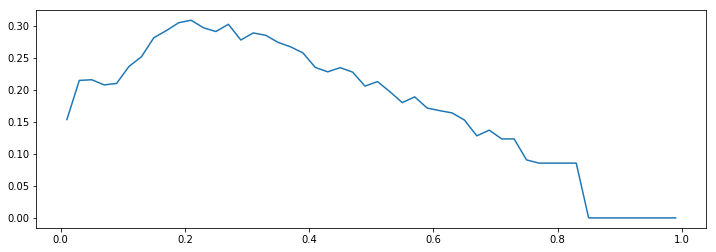

In [11]:
from sklearn.cross_validation import StratifiedKFold
clf = XGBClassifier(
    learning_rate = 0.01,
    n_estimators = 420,
    max_depth=5,
    gamma = 0.1,
    min_child_weight = 1
)
cv = StratifiedKFold(y,n_folds=4)
preds = np.ones(y.shape[0])
for i, (tr,te) in enumerate(cv):
    preds[te] = clf.fit(train[tr],y[tr]).predict_proba(train[te])[:,1]

thresholds = np.linspace(0.01,0.99,50)
mcc = np.array([matthews_corrcoef(y,preds>thr) for thr in thresholds])
plt.plot(thresholds,mcc)

In [12]:
print(mcc.max())

0.309058232151
